In [1]:
import os
import torch
from torch import nn
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from clipseg_model import CLIPSeg
from data.cub_parts_dataset import CUBPartsDataset, collate_fn

%load_ext autoreload
%autoreload 2

In [13]:
from clipseg_train import load_concepts
state_dict = torch.load('checkpoints/clipseg_pascub_ft.pt')

with open('concepts/CUB/parts.txt') as fp:
    part_texts = fp.read().splitlines()

concept_sets = load_concepts()

model = CLIPSeg(
    part_texts=part_texts,
    concepts_dict=concept_sets,
    meta_category_text='bird',
    k=50,
    state_dict=state_dict
)

# trained_state_dict = torch.load('checkpoints/checkpoint_stage2.pt')
# model.load_state_dict(trained_state_dict)

Some weights of CLIPSegForImageSegmentation were not initialized from the model checkpoint at CIDAS/clipseg-rd64-refined and are newly initialized: ['non_object_embedding', 'text_adapter.fc.0.weight', 'text_adapter.fc.2.weight', 'tunable_linear.weight', 'visual_adapter.fc.0.weight', 'visual_adapter.fc.2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<class 'clipseg.configuration_clipseg.CLIPSegConfig'> 512


In [14]:
dataset_test = CUBPartsDataset('datasets/PASCUB', split='test')
dataloader_test = DataLoader(dataset=dataset_test, batch_size=4, shuffle=False, collate_fn=collate_fn)
dataloader_test_iter = iter(dataloader_test)

In [20]:
# inference
batch = next(dataloader_test_iter)
batch
model.eval()
with torch.no_grad():
    img_paths, label_paths, imgs, labels = batch
    imgs = list(imgs)
    logits = model.inference(imgs)

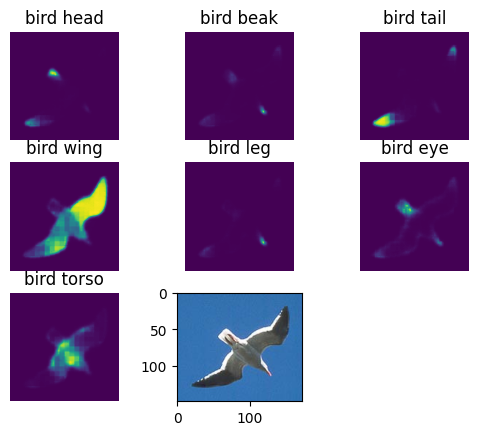

In [21]:
fig, axes = plt.subplots(3, 3)
for score_map, ax, text in zip(logits[0].cpu().numpy(), axes.flatten(), model.part_texts):
    ax.imshow(score_map)
    ax.axis('off')
    ax.title.set_text(text)

axes[-1,-2].imshow(batch[2][0].permute(1,2,0))
fig.delaxes(axes[-1,-1])